In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Basics
import tensorflow as tf
import xarray as xr
import random

# Helpful
import tqdm

# Visualization
import matplotlib.pyplot as plt

# Path setup
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_local_scores
from src.models.EMOS_local.EMOS_local_load_model import *  # Load EMOS_local_models
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_score import *  # Load DRN_scores
from src.models.DRN.DRN_load_score_10 import *  # Load DRN_scores_10
from src.models.DRN.DRN_load_score_dummy_10 import *  # Load DRN_scores_10
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

<IPython.core.display.Javascript object>

### 0. Set Up

In [3]:
# Decide on lead times, to not load too much
lead_times = range(1, 32)
lead_times_hours = [str(lead * 6) + "h" for lead in lead_times]

<IPython.core.display.Javascript object>

### 1. Load data

In [46]:
# Only raw data, because individual ensemble forecasts needed:
raw_data = ldr.load_data_raw()
# t2m data
t2m_val_data_X = []
t2m_val_data_y = []
t2m_test_data_X = []
t2m_test_data_y = []
for lead in lead_times:
    t2m_val_data_X.append(raw_data[3].predictions.isel(var=2, lead_time=lead))
    t2m_val_data_y.append(raw_data[3].ground_truth.isel(var=2, lead_time=lead))
    t2m_test_data_X.append(raw_data[4].predictions.isel(var=2, lead_time=lead))
    t2m_test_data_y.append(raw_data[4].ground_truth.isel(var=2, lead_time=lead))

<IPython.core.display.Javascript object>

In [5]:
raw_data = ldr.load_data_raw()
# ws10 data
ws10_val_data_X = []
ws10_val_data_y = []
ws10_test_data_X = []
ws10_test_data_y = []
# First u10 and v10
for lead in lead_times:
    ws10_val_data_X.append(
        np.sqrt(
            np.add(
                np.power(raw_data[3].predictions.isel(var=0, lead_time=lead), 2),
                np.power(raw_data[3].predictions.isel(var=1, lead_time=lead), 2)
            )
        )
    )
    ws10_val_data_y.append(
        np.sqrt(
            np.add(
                np.power(raw_data[3].ground_truth.isel(var=0, lead_time=lead), 2),
                np.power(raw_data[3].ground_truth.isel(var=1, lead_time=lead), 2)
            )
        )
    )
    ws10_test_data_X.append(
        np.sqrt(
            np.add(
                np.power(raw_data[4].predictions.isel(var=0, lead_time=lead), 2),
                np.power(raw_data[4].predictions.isel(var=1, lead_time=lead), 2)
            )
        )
    )
    ws10_test_data_y.append(
        np.sqrt(
            np.add(
                np.power(raw_data[4].ground_truth.isel(var=0, lead_time=lead), 2),
                np.power(raw_data[4].ground_truth.isel(var=1, lead_time=lead), 2)
            )
        )
    )


<IPython.core.display.Javascript object>

### 2. t2m 3D verification rank histogram

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


def plot_3d_rank_histogram(ensemble_forecasts, ground_truth):
    """
    Plots a 3D verification rank histogram for ensemble forecasts.

    The function takes as input two lists of xarray DataArrays, one representing ensemble forecasts
    and the other representing ground truth values. It then computes the rank of each ground truth
    value within the ensemble forecasts and uses these ranks to create a 3D histogram.

    Parameters
    ----------
    ensemble_forecasts : list of xarray.DataArray
        A list of xarray DataArrays containing the ensemble forecasts. Each DataArray should have the dimensions
        ('forecast_date', 'ens', 'lat', 'lon').
    ground_truth : list of xarray.DataArray
        A list of xarray DataArrays containing the ground truth values. Each DataArray should have the dimensions
        ('forecast_date', 'lat', 'lon').

    Returns
    -------
    None
        This function doesn't return a value. It directly plots the 3D rank histogram.

    Raises
    ------
    AssertionError
        If the inputs are not lists of xarray DataArrays.
    """
    # Ensure the input data are lists of xarray DataArrays
    assert isinstance(ensemble_forecasts, list)
    assert isinstance(ground_truth, list)
    assert all(isinstance(da, xr.DataArray) for da in ensemble_forecasts)
    assert all(isinstance(da, xr.DataArray) for da in ground_truth)

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Initialize the maximum frequency
    max_frequency = 0

    # Loop through each lead time
    for lead_time_idx, (ensemble_forecast, ground_truth_data) in enumerate(
        zip(ensemble_forecasts, ground_truth)
    ):
        # Stack the ensemble forecasts and ground truth arrays along new dimensions
        ensemble_forecasts_flat = ensemble_forecast.stack(z=("lat", "lon"))
        ground_truth_flat = ground_truth_data.stack(z=("lat", "lon"))

        # Calculate the rank of the ground truth within the ensemble forecasts
        ranks = (ensemble_forecasts_flat < ground_truth_flat).sum("ens") + 1

        # Compute the histogram
        hist, bin_edges = np.histogram(
            ranks.values.flatten(),
            bins=np.arange(1, ensemble_forecast["ens"].size + 3),
            density=False,
        )

        # Normalize the histogram
        hist = hist / hist.sum()

        # Update the maximum frequency if necessary
        max_frequency = max(max_frequency, hist.max())

        # Plot the histogram as a 3D bar plot
        xs = bin_edges[:-1]
        ys = hist
        zs = np.full_like(
            xs, (lead_time_idx + 1) * 6
        )  # Create an array with lead time index repeated for each bin
        ax.bar(xs, ys, zs=zs, zdir="y", alpha=1)

    # Set plot labels and title
    ax.set_xlabel("Rank")
    ax.set_ylabel("Lead Time in hours")
    ax.set_zlabel("Frequency")
    ax.set_title("3D Verification Rank Histogram: ws10")

    # Set the z-axis limits to match the maximum normalized frequency
    ax.set_zlim(0, max_frequency)
    plt.savefig(
        f"/home/dchen/BA_CH_EN/reports/figures/verification_rank_hist_3D_ws10.pdf"
    )
    # Show the plot
    plt.show()

<IPython.core.display.Javascript object>

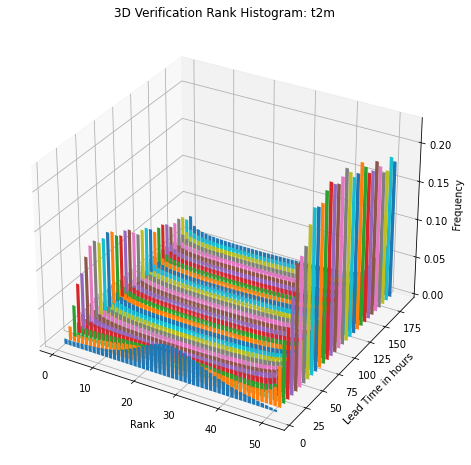

<IPython.core.display.Javascript object>

In [48]:
plot_3d_rank_histogram(t2m_test_data_X, t2m_test_data_y)

### 3. ws10 verification rank histogram

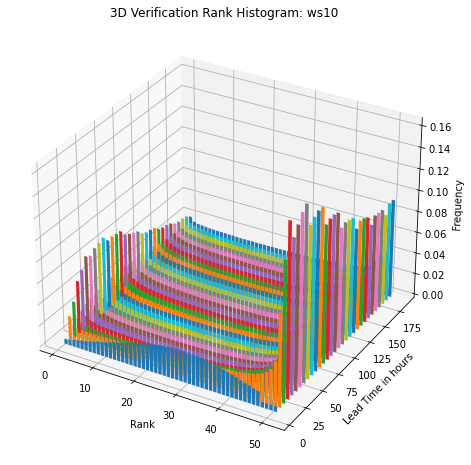

<IPython.core.display.Javascript object>

In [7]:
plot_3d_rank_histogram(ws10_test_data_X, ws10_test_data_y)